<a href="https://colab.research.google.com/github/Jin-K-Yang/Clustering-by-Louvain-Algorithm/blob/main/louvain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

5414
12370
{'0200': 0, 'C172672': 0, '0201': 1, '1202': 2, 'C177615': 3, '1205': 3, '1225': 4, '1104': 5, 'C254423': 5, '0205': 6, 'C77075': 7, '1002': 7, '0139': 8, 'B0547': 8, '1101': 9, 'C138846': 1, '0600': 2, 'C201813': 2, 'C22967': 1, '1102': 0, '1243': 6, '1109': 5, 'C232096': 10, '1207': 10, '0009': 11, 'C233698': 22, '0401': 11, '0702': 2, 'C257595': 2, '0902': 2, '9999': 1, 'C260283': 2, 'C52348': 7, '1029': 7, '9004': 10, 'C78513': 10, '0725': 4, 'C98409': 5, '1103': 5, 'C128608': 5, 'C130768': 1, '1007': 1, 'C135737': 1, 'C154479': 2, '0707': 10, 'C179026': 10, '0729': 13, 'C22083': 13, '0932': 13, '0202': 14, 'C223991': 14, 'C224105': 4, '1107': 15, 'C50633': 15, '0303': 4, 'C63888': 4, '1100': 16, 'C78003': 16, 'C88042': 9, 'B0509': 0, '0203': 14, 'C08854': 14, '0601': 14, 'C139828': 6, 'C190202': 15, '1105': 15, 'C251915': 5, 'C54747': 1, 'C55896': 7, 'C02710': 5, 'C169135': 11, 'C228204': 1, 'C248858': 17, '1020': 17, 'C248875': 1, 'C262164': 0, 'C262165': 18, '1106': 1

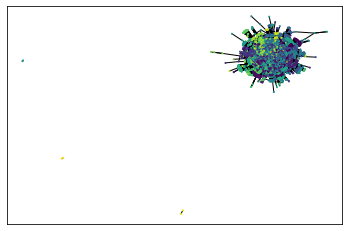

In [4]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

# load excel file
df = pd.read_excel('20200420-20200506.xlsx', '20200420-0506', usecols='F, K', converters={'部門':str})

# convert into two array which represent customer and product
array = df.to_numpy()
split_array = np.hsplit(array, 2)
customer = split_array[0]
product = split_array[1]

# construct bipartite graph
G = nx.Graph()
for i in range(len(product)):
    # zero padding
    product[i][0] = product[i][0].zfill(4)

    # add nodes
    G.add_nodes_from(product[i], bipartite = 0)
    G.add_nodes_from(customer[i], bipartite = 1)
    
    # add edges
    if G.has_edge(product[i][0], customer[i][0]):
        G[product[i][0]][customer[i][0]]['weight'] += 1
    else:
        G.add_edge(product[i][0], customer[i][0], weight = 1)

# show the total number of nodes and edges
print(G.number_of_nodes())
print(G.number_of_edges())

# compute the best partition
partition = community_louvain.best_partition(G)
print(partition)

# draw the graph
pos = nx.spring_layout(G)

# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=1, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=1)
plt.show()